In [1]:
import pandas as pd
import ORE as ql

In [2]:
today = ql.Date(25, ql.October, 2021)
ql.Settings.instance().evaluationDate = today

In [3]:
index = ql.Sofr()

In [4]:
futures_data = [
    ((11, 2021, ql.Monthly), 99.934),
    ((12, 2021, ql.Monthly), 99.922),
    ((1, 2022, ql.Monthly), 99.914),
    ((2, 2022, ql.Monthly), 99.919),
    ((3, 2022, ql.Quarterly), 99.876),
    ((6, 2022, ql.Quarterly), 99.799),
    ((9, 2022, ql.Quarterly), 99.626),
    ((12, 2022, ql.Quarterly), 99.443),
]

In [5]:
ois_data = [
    ("1Y", 0.137),
    ("2Y", 0.409),
    ("3Y", 0.674),
    ("5Y", 1.004),
    ("8Y", 1.258),
    ("10Y", 1.359),
    ("12Y", 1.420),
    ("15Y", 1.509),
    ("20Y", 1.574),
    ("25Y", 1.586),
    ("30Y", 1.579),
    ("35Y", 1.559),
    ("40Y", 1.514),
    ("45Y", 1.446),
    ("50Y", 1.425),
]

In [6]:
futures_helpers = []

for (month, year, frequency), price in futures_data:
    q = ql.SimpleQuote(price)
    futures_helpers.append(
        ql.SofrFutureRateHelper(ql.QuoteHandle(q), month, year, frequency)
    )

In [7]:
settlement_days = 2

ois_quotes = {}
ois_helpers = []

for tenor, quote in ois_data:
    q = ql.SimpleQuote(quote / 100.0)
    ois_quotes[tenor] = q
    ois_helpers.append(
        ql.OISRateHelper(
            settlement_days,
            ql.Period(tenor),
            ql.QuoteHandle(q),
            index,
            paymentFrequency=ql.Annual,
        )
    )

In [8]:
cutoff_date = futures_helpers[-1].latestDate() + ql.Period(1, ql.Months)
ois_helpers = [h for h in ois_helpers if h.latestDate() > cutoff_date]

In [9]:
sofr_curve = ql.PiecewiseLogCubicDiscount(
    0,
    ql.UnitedStates(ql.UnitedStates.GovernmentBond),
    futures_helpers + ois_helpers,
    ql.Actual360(),
)

In [10]:
pd.DataFrame(sofr_curve.nodes(), columns=["date", "discount factor"])

,date,discount factor
0,"October 25th, 2021",1.000000
1,"December 1st, 2021",0.999933
2,"January 1st, 2022",0.999866
3,"February 1st, 2022",0.999792
4,"March 1st, 2022",0.999729
5,"June 15th, 2022",0.999378
6,"September 21st, 2022",0.998831
7,"December 21st, 2022",0.997888
8,"March 15th, 2023",0.996593
9,"October 27th, 2023",0.991743


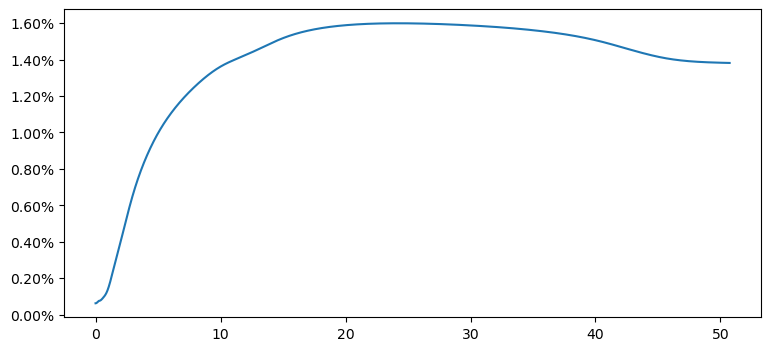

In [11]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

ax = plt.figure(figsize=(9, 4)).add_subplot(1, 1, 1)
ax.yaxis.set_major_formatter(FuncFormatter(lambda r, pos: f"{r:.2%}"))
times = np.linspace(0.0, sofr_curve.maxTime(), 2500)
rates = [sofr_curve.zeroRate(t, ql.Continuous).rate() for t in times]
ax.plot(times, rates);

In [12]:
sofr_handle = ql.YieldTermStructureHandle(sofr_curve)

index = ql.Sofr(sofr_handle)

start_date = index.fixingCalendar().advance(
    today, settlement_days, ql.Days
)
end_date = index.fixingCalendar().advance(
    start_date,
    ql.Period(20, ql.Years),
    index.businessDayConvention(),
    index.endOfMonth(),
)
schedule = ql.Schedule(
    start_date,
    end_date,
    ql.Period(ql.Annual),
    index.fixingCalendar(),
    index.businessDayConvention(),
    index.businessDayConvention(),
    ql.DateGeneration.Forward,
    index.endOfMonth(),
)

swap = ql.OvernightIndexedSwap(
    ql.Swap.Payer,
    1_000_000,
    schedule,
    0.0,
    index.dayCounter(),
    index,
)
swap.setPricingEngine(ql.DiscountingSwapEngine(sofr_handle))

In [13]:
print(swap.fairRate())

0.015739999999987077
